# Class of Method

SEOYEON CHOI  
2023-01-21

> Class

# import

In [1]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

import torch
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

import matplotlib.pyplot as plt
import pandas as pd

import time

from scipy.interpolate import interp1d

from matplotlib import animation

In [2]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# 시간 측정 방법

``` python
t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1
```

# R

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(GNAR)
library(igraph)

R[write to console]: Loading required package: igraph

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union


R[write to console]: Loading required package: wordcloud

R[write to console]: Loading required package: RColorBrewer


# Data

In [5]:
%%R
edges <- as.matrix(fiveNet)
data("fiveNode")

In [6]:
%R -o fiveVTS
%R -o edges

-   node: 5
-   time 200

# functions

In [7]:
def vis(spatiotemporaldata):
    N = spatiotemporaldata.shape[1]
    fig, ax = plt.subplots(N,1)
    for n in range(N):
        ax[n].plot(spatiotemporaldata[:,n])
        ax[n].set_title('node='+str(n))
    #fig.set_width()
    fig.set_figheight(N*2) 
    fig.tight_layout()
    return fig 

In [8]:
def vis2(spatiotemporaldata1,spatiotemporaldata2):
    N = spatiotemporaldata1.shape[1]
    fig, ax = plt.subplots(N,1)
    for n in range(N):
        ax[n].plot(spatiotemporaldata1[:,n],label='data1')
        ax[n].plot(spatiotemporaldata2[:,n],label='data2')
        ax[n].set_title('node='+str(n))
        ax[n].legend()
    #fig.set_width()
    fig.set_figheight(N*2) 
    fig.tight_layout()
    return fig 

In [9]:
edges_tensor = torch.tensor(edges)

In [10]:
nonzero_indices = edges_tensor.nonzero()

In [11]:
fiveNet_edge = np.array(nonzero_indices).T

In [12]:
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1

In [13]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

In [14]:
fiveVTS_train = fiveVTS[:int(len(fiveVTS)*0.8)]
fiveVTS_test = fiveVTS[int(len(fiveVTS)*0.8):]

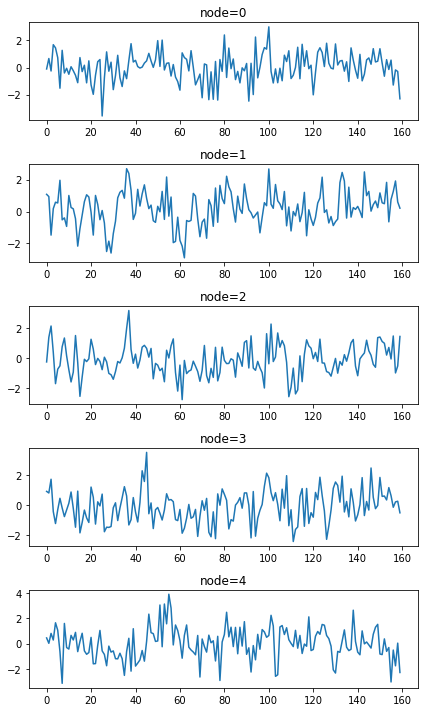

In [15]:
vis(fiveVTS_train);

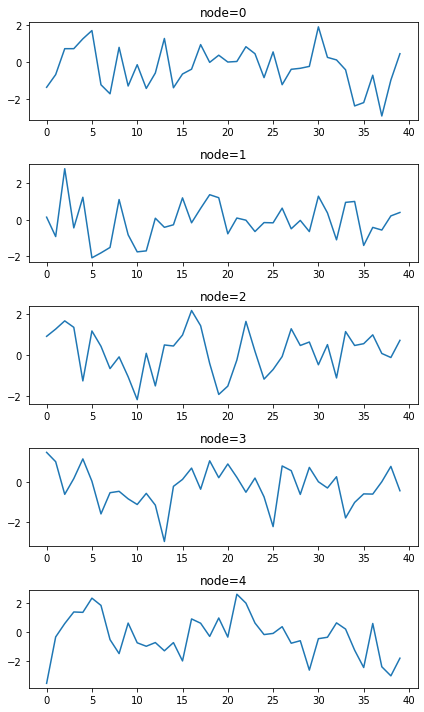

In [16]:
vis(fiveVTS_test);

# Random Missing Values

In [25]:
class Missing:
    def __init__(self,df):
        self.df = df
        self.N = N
        self.number = []
    def miss(self,percent=0.5):
        self.missing = self.df.copy()
        self.percent = percent
        for i in range(self.N):
            self.seed = np.random.choice(1000,1,replace=False)
            np.random.seed(self.seed)
            self.number.append(np.random.choice(int(len(self.df))-1,int(len(self.df)*self.percent),replace=False))
            self.missing[self.number[i],i] = float('nan')
    def first_mean(self):
        self.train_mean = self.missing.copy()
        for i in range(self.N):
            self.train_mean[self.number[i],i] = np.nanmean(self.missing[:,i])
    def second_linear(self):
        self.train_linear = pd.DataFrame(self.missing)
        self.train_linear.interpolate(method='linear', inplace=True)
        self.train_linear = self.train_linear.fillna(0)
        self.train_linear = np.array(self.train_linear).reshape(int(len(self.df)),N)

In [26]:
type(fiveVTS_train)

In [27]:
fiveVTS_train.shape

In [28]:
_zero = Missing(fiveVTS_train)

In [29]:
_zero.miss(percent = 0.1)

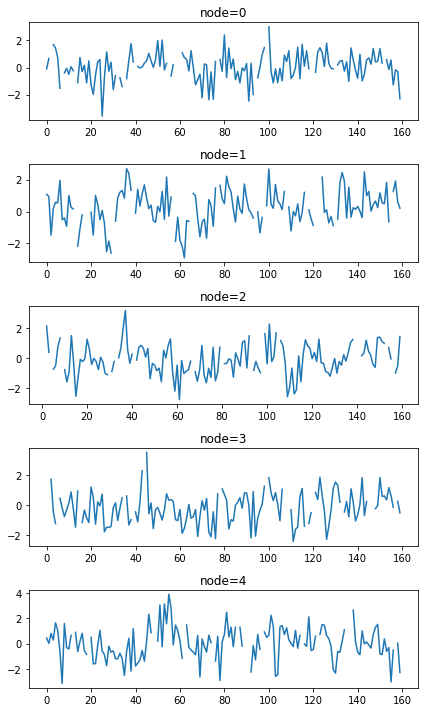

In [31]:
vis(_zero.missing);

In [32]:
_zero.first_mean()

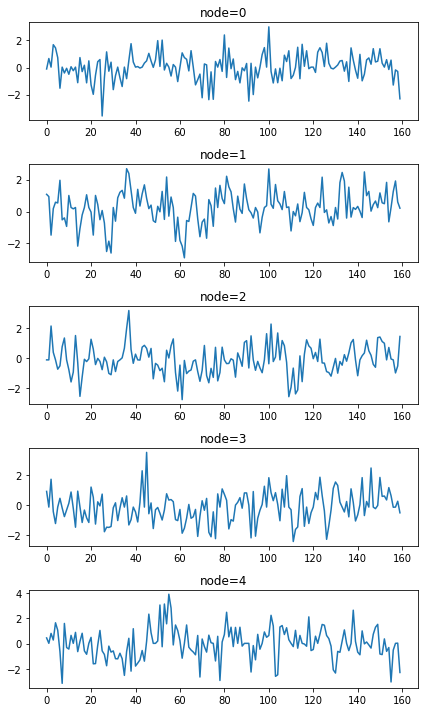

In [33]:
vis(_zero.train_mean);

In [34]:
_zero.second_linear()

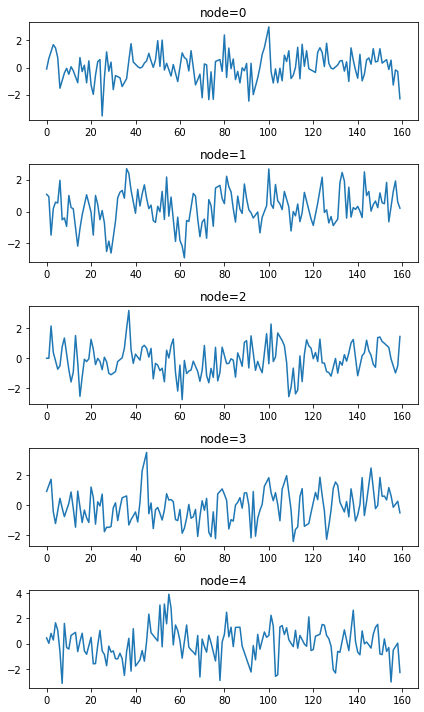

In [35]:
vis(np.array(_zero.train_linear).reshape(160,5));

In [36]:
train_X_mean = torch.tensor(_zero.train_mean).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
train_y_mean = torch.tensor(_zero.train_mean).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [28]:
train_X_linear = torch.tensor(_zero.train_linear).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
train_y_linear = torch.tensor(_zero.train_linear).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [29]:
xt_test = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[:-1,:,:]).float()

In [128]:
class Method:
    def __init__(self,df,time,seednumber,trainx,trainy):
        self.test_data = fiveVTS_test
        self.seednumber = seednumber
        self.N = N
        self.timepoint = time -1
        self.edge_index = edge_index
        self.edge_attr = edge_attr
        self.node_features = node_features
        self.X = trainx
        self.df = _zero.train_mean
        self.y = trainy
        self.xt_test = xt_test
        self.w = np.zeros(((self.timepoint)*self.N,(self.timepoint)*self.N))
        self.mse = []
        self.mae = []
        self.train_result_list = []
        self.test_result_list = []
    def _weight(self):
        for i in range((self.timepoint)*self.N):
            for j in range((self.timepoint)*self.N):
                if i==j :
                    self.w[i,j] = 0
                elif np.abs(i-j) <= 1 : 
                    self.w[i,j] = 1
    def _STGCN(self):
        model = RecurrentGCN(node_features=1, filters=4)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        model.train()
        for epoch in tqdm(range(100)):
            for time, (xt,yt) in enumerate(zip(self.X,self.y)):
                y_hat = model(xt, edge_index, edge_attr)
                cost = torch.mean((y_hat-yt)**2)
                cost.backward()
                optimizer.step()
                optimizer.zero_grad()
        self.train_result = torch.stack([model(xt, edge_index, edge_attr) for xt in self.X]).detach().numpy()
        self.test_result = torch.stack([model(xt, edge_index, edge_attr) for xt in self.xt_test]).detach().numpy()
        self.train_result_list.append(self.train_result)
        self.test_result_list.append(self.test_result)
        for i in range(self.N):
            self.mse.append(np.mean((self.test_data[1:,i] - self.test_result.reshape(int(len(self.xt_test)),self.N)[:,i])**2))
        for i in range(self.N):
            self.mae.append(np.mean(np.abs(self.test_data[1:,i] - self.test_result.reshape(int(len(self.xt_test)),self.N)[:,i])))
    def FT(self):
        self._weight()
        self._STGCN()
        self.d = np.array(self.w.sum(axis=1))
        self.D = np.diag(self.d)
        self.L = np.array(np.diag(1/np.sqrt(self.d)) @ (self.D-self.w) @ np.diag(1/np.sqrt(self.d)))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)
        self.fhatbar = self.Psi.T @ self.train_result.reshape((self.timepoint)*self.N,1)
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.fhatbar_threshed = ebayesthresh(FloatVector(self.fhatbar))
        self.fhatbarhat = self.Psi @ self.fhatbar_threshed
        self.FT_result = self.fhatbarhat.reshape(self.timepoint,self.N,1)
        for i in range(N): 
            self.df[self.seednumber[i],i] = torch.tensor(self.FT_result)[self.seednumber[i],i,0]

In [407]:
def show_lrpr(data1,data2,data3,data4,data5,history):
    y1,y2,y3,y4,y5 = data1,data2,data3,data4,data5
    
    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(5, 1, 1)
    ax2 = fig.add_subplot(5, 1, 2)
    ax3 = fig.add_subplot(5, 1, 3)
    ax4 = fig.add_subplot(5, 1, 4)
    ax5 = fig.add_subplot(5, 1, 5)
    
    ax1.plot(y1)
    ax2.plot(y2)
    ax3.plot(y3)
    ax4.plot(y4)
    ax5.plot(y5)
    line1, = ax1.plot(history[0][:,0,0])
    line2, = ax2.plot(history[0][:,1,0])
    line3, = ax3.plot(history[0][:,2,0]) 
    line4, = ax4.plot(history[0][:,3,0]) 
    line5, = ax5.plot(history[0][:,4,0]) 

    def animate(epoc):
        line1.set_ydata(history[epoc][:,0,0])
        line2.set_ydata(history[epoc][:,1,0])
        line3.set_ydata(history[epoc][:,2,0])
        line4.set_ydata(history[epoc][:,3,0])
        line5.set_ydata(history[epoc][:,4,0])
        return line1,line2,line3,line4,line5

    ani = animation.FuncAnimation(fig, animate, frames=30)
    plt.close()
    return ani

# missing : 10%

In [27]:
train_X_mean = torch.tensor(_zero.train_mean).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
train_y_mean = torch.tensor(_zero.train_mean).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [28]:
train_X_linear = torch.tensor(_zero.train_linear).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
train_y_linear = torch.tensor(_zero.train_linear).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [137]:
___zero = Missing(fiveVTS_train)

In [138]:
___zero.miss(percent = 0.1)

In [139]:
___zero.first_mean()

In [140]:
___zero.second_linear()

## Mean

In [142]:
t1= time.time()
ttt = 160
_mse = []
_mae = []
_train_result = []
_test_result = []
b = ___zero.train_mean
c = ___zero.number
d = train_X_mean
f = train_y_mean
for i in range(60):
    a = Method(b,ttt,c,d,f)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    _train_result.append(a.train_result)
    _test_result.append(a.test_result)
    b = a.FT_result
t2 = time.time()
t2-t1

100%|██████████| 100/100 [00:53<00:00,  1.87it/s]

In [143]:
mean_mse100_10 = pd.DataFrame(_mse)

In [146]:
mean_mae100_10 = pd.DataFrame(_mae)

In [192]:
_train_result_mean10 = _train_result.copy()

In [193]:
_test_result_mean10 = _test_result.copy()

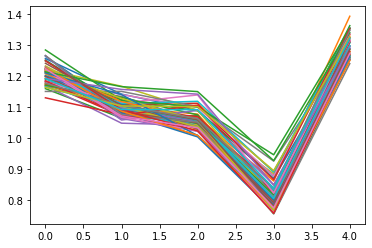

In [149]:
plt.plot(mean_mse100_10.T);

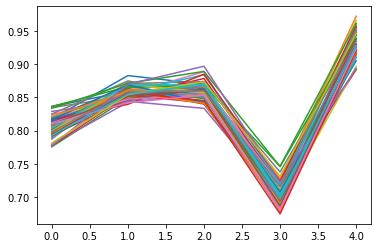

In [150]:
plt.plot(mean_mae100_10.T);

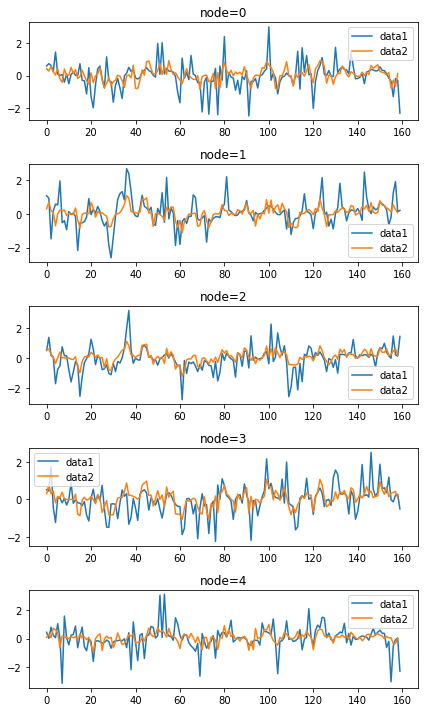

In [186]:
vis2(_zero.train_mean,_train_result[59]);

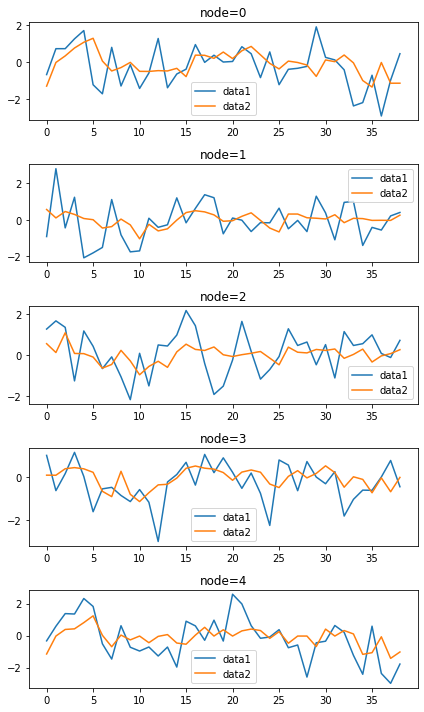

In [185]:
vis2(fiveVTS_test[1:],_test_result[0]);

## Linear

In [194]:
t1= time.time()
ttt = 160
_mse = []
_mae = []
_train_result = []
_test_result = []
b = ___zero.second_linear
c = ___zero.number
d = train_X_linear
f = train_y_linear
for i in range(60):
    a = Method(b,ttt,c,d,f)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    _train_result.append(a.train_result)
    _test_result.append(a.test_result)
    b = a.FT_result
t2 = time.time()
t2-t1

100%|██████████| 100/100 [00:54<00:00,  1.84it/s]

In [195]:
linear_mse100_10 = pd.DataFrame(_mse)

In [196]:
linear_mae100_10 = pd.DataFrame(_mae)

In [197]:
_train_result_linear10 = _train_result.copy()

In [198]:
_test_result_linear10 = _test_result.copy()

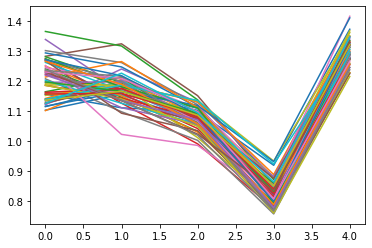

In [199]:
plt.plot(linear_mse100_10.T);

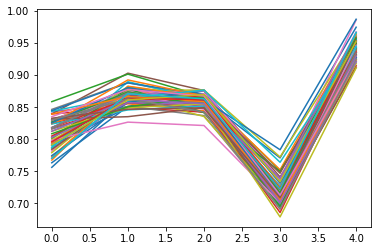

In [200]:
plt.plot(linear_mae100_10.T);

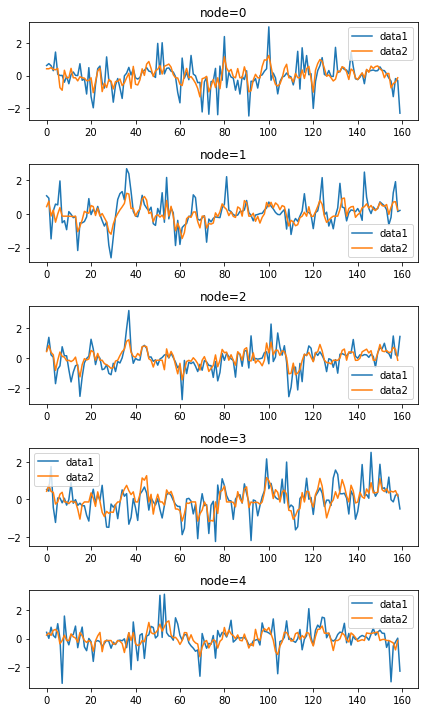

In [201]:
vis2(_zero.train_mean,_train_result_linear10[59]);

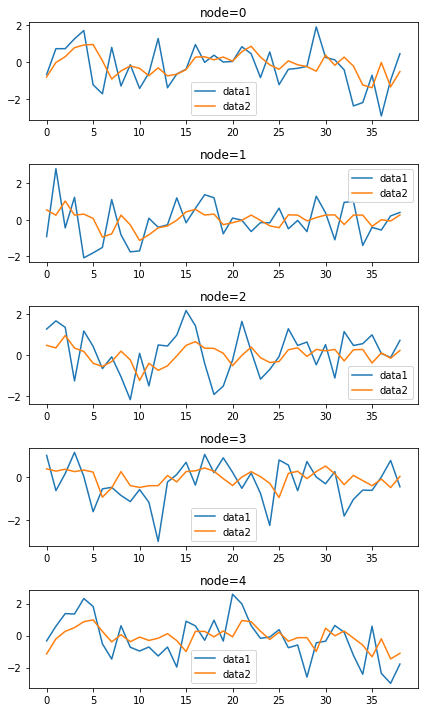

In [202]:
vis2(fiveVTS_test[1:],_test_result_linear10[0]);

# missing : 20%

In [203]:
train_X_mean = torch.tensor(_zero.train_mean).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
train_y_mean = torch.tensor(_zero.train_mean).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [204]:
train_X_linear = torch.tensor(_zero.train_linear).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
train_y_linear = torch.tensor(_zero.train_linear).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [205]:
___zero20 = Missing(fiveVTS_train)

In [206]:
___zero20.miss(percent = 0.2)

In [207]:
___zero20.first_mean()

In [208]:
___zero20.second_linear()

## Mean

In [209]:
t1= time.time()
ttt = 160
_mse = []
_mae = []
_train_result = []
_test_result = []
b = ___zero20.train_mean
c = ___zero20.number
d = train_X_mean
f = train_y_mean
for i in range(60):
    a = Method(b,ttt,c,d,f)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    _train_result.append(a.train_result)
    _test_result.append(a.test_result)
    b = a.FT_result
t2 = time.time()
t2-t1

100%|██████████| 100/100 [00:53<00:00,  1.86it/s]

In [210]:
mean_mse100_20 = pd.DataFrame(_mse)

In [211]:
mean_mae100_20 = pd.DataFrame(_mae)

In [212]:
_train_result_mean20 = _train_result.copy()

In [213]:
_test_result_mean20 = _test_result.copy()

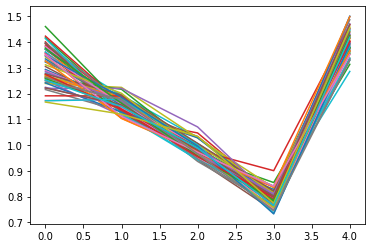

In [214]:
plt.plot(mean_mse100_20.T);

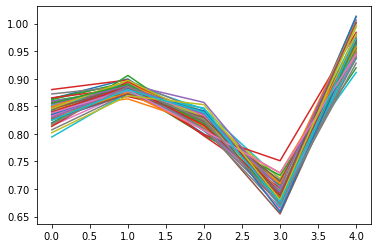

In [215]:
plt.plot(mean_mae100_20.T);

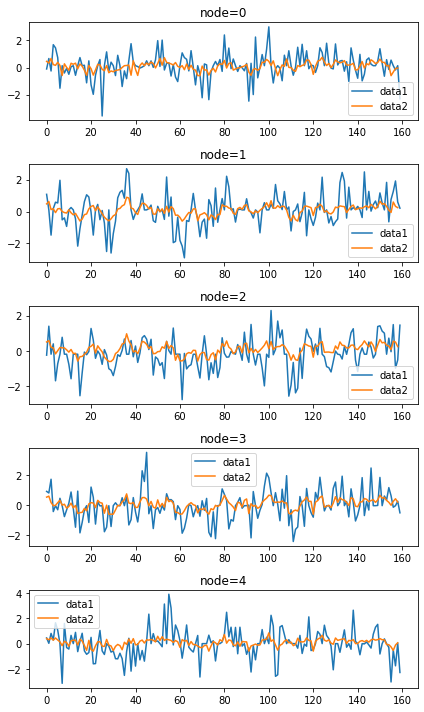

In [216]:
vis2(___zero20.train_mean,_train_result_mean20[59]);

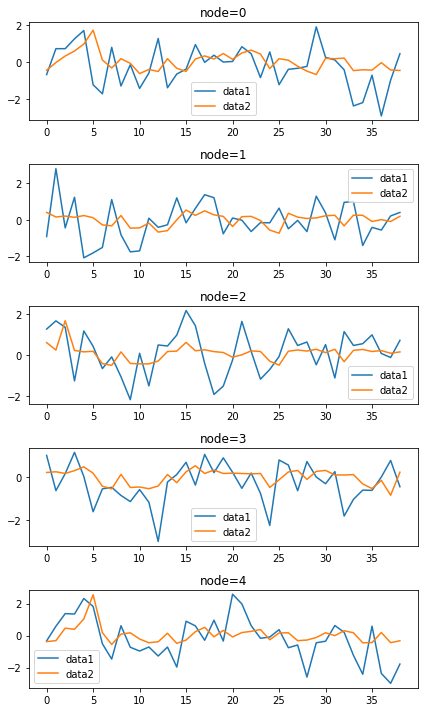

In [217]:
vis2(fiveVTS_test[1:],_test_result_mean20[0]);

In [408]:
show_lrpr(fiveVTS_test[1:,0],fiveVTS_test[1:,1],fiveVTS_test[1:,2],fiveVTS_test[1:,3],fiveVTS_test[1:,4],_test_result_mean20)

## Linear

In [218]:
t1= time.time()
ttt = 160
_mse = []
_mae = []
_train_result = []
_test_result = []
b = ___zero20.second_linear
c = ___zero20.number
d = train_X_linear
f = train_y_linear
for i in range(60):
    a = Method(b,ttt,c,d,f)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    _train_result.append(a.train_result)
    _test_result.append(a.test_result)
    b = a.FT_result
t2 = time.time()
t2-t1

100%|██████████| 100/100 [00:54<00:00,  1.84it/s]

In [219]:
linear_mse100_20 = pd.DataFrame(_mse)

In [220]:
linear_mae100_20 = pd.DataFrame(_mae)

In [221]:
_train_result_linear20 = _train_result.copy()

In [222]:
_test_result_linear20 = _test_result.copy()

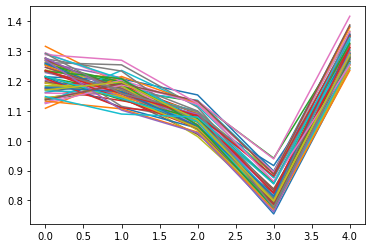

In [223]:
plt.plot(linear_mse100_20.T);

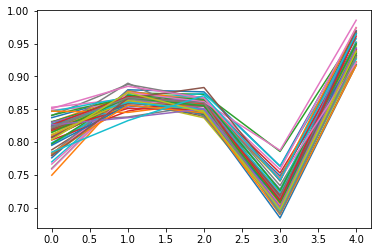

In [224]:
plt.plot(linear_mae100_20.T);

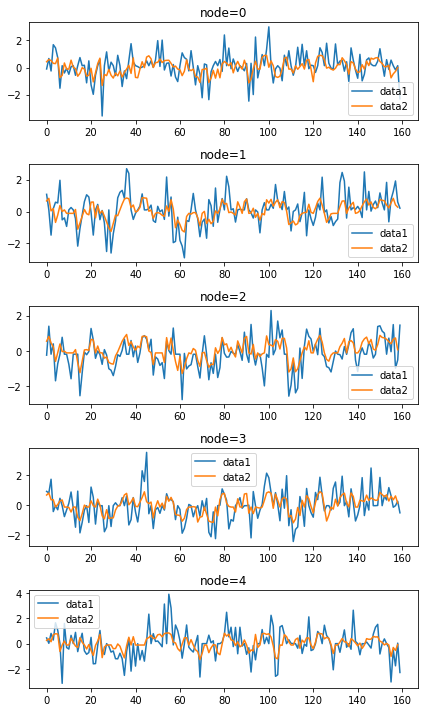

In [225]:
vis2(___zero20.train_mean,_train_result_linear20[59]);

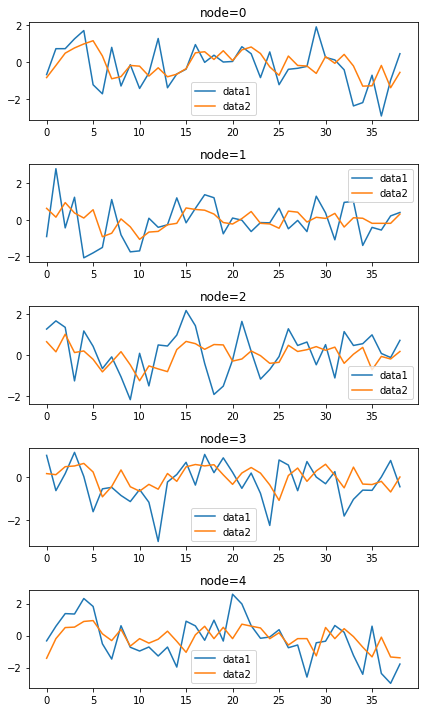

In [226]:
vis2(fiveVTS_test[1:],_test_result_linear20[0]);

In [414]:
show_lrpr(fiveVTS_test[1:,0],fiveVTS_test[1:,1],fiveVTS_test[1:,2],fiveVTS_test[1:,3],fiveVTS_test[1:,4],_test_result_linear20)

# missing : 30%

In [227]:
train_X_mean = torch.tensor(_zero.train_mean).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
train_y_mean = torch.tensor(_zero.train_mean).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [228]:
train_X_linear = torch.tensor(_zero.train_linear).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
train_y_linear = torch.tensor(_zero.train_linear).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [229]:
___zero30 = Missing(fiveVTS_train)

In [230]:
___zero30.miss(percent = 0.3)

In [231]:
___zero30.first_mean()

In [232]:
___zero30.second_linear()

## Mean

In [233]:
t1= time.time()
ttt = 160
_mse = []
_mae = []
_train_result = []
_test_result = []
b = ___zero30.train_mean
c = ___zero30.number
d = train_X_mean
f = train_y_mean
for i in range(60):
    a = Method(b,ttt,c,d,f)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    _train_result.append(a.train_result)
    _test_result.append(a.test_result)
    b = a.FT_result
t2 = time.time()
t2-t1

100%|██████████| 100/100 [00:53<00:00,  1.87it/s]

In [234]:
mean_mse_30 = pd.DataFrame(_mse)

In [235]:
mean_mae_30 = pd.DataFrame(_mae)

In [236]:
_train_result_mean30 = _train_result.copy()

In [237]:
_test_result_mean30 = _test_result.copy()

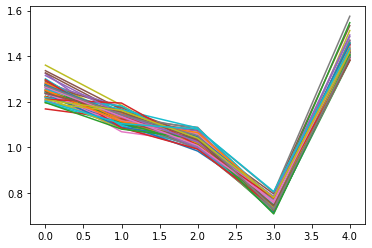

In [238]:
plt.plot(mean_mse_30.T);

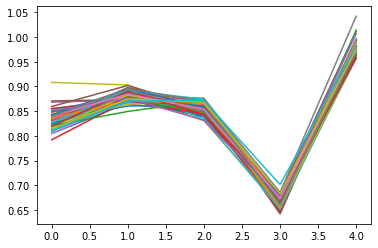

In [239]:
plt.plot(mean_mae_30.T);

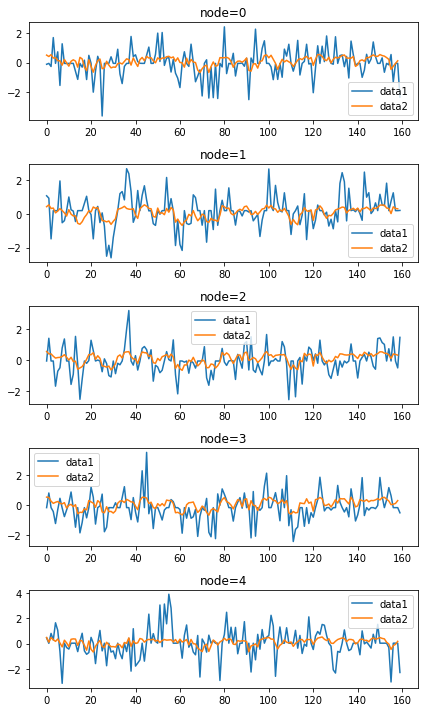

In [240]:
vis2(___zero30.train_mean,_train_result_mean30[59]);

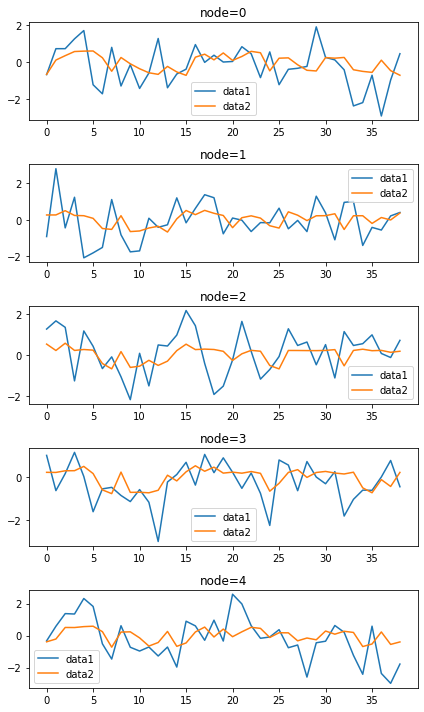

In [241]:
vis2(fiveVTS_test[1:],_test_result_mean30[0]);

In [415]:
show_lrpr(fiveVTS_test[1:,0],fiveVTS_test[1:,1],fiveVTS_test[1:,2],fiveVTS_test[1:,3],fiveVTS_test[1:,4],_test_result_mean30)

## Linear

In [242]:
t1= time.time()
ttt = 160
_mse = []
_mae = []
_train_result = []
_test_result = []
b = ___zero30.second_linear
c = ___zero30.number
d = train_X_linear
f = train_y_linear
for i in range(60):
    a = Method(b,ttt,c,d,f)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    _train_result.append(a.train_result)
    _test_result.append(a.test_result)
    b = a.FT_result
t2 = time.time()
t2-t1

100%|██████████| 100/100 [00:54<00:00,  1.84it/s]

In [243]:
linear_mse_30 = pd.DataFrame(_mse)

In [244]:
linear_mae_30 = pd.DataFrame(_mae)

In [245]:
_train_result_linear30 = _train_result.copy()

In [246]:
_test_result_linear30 = _test_result.copy()

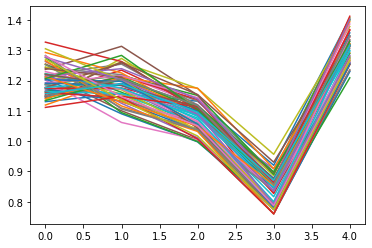

In [247]:
plt.plot(linear_mse_30.T);

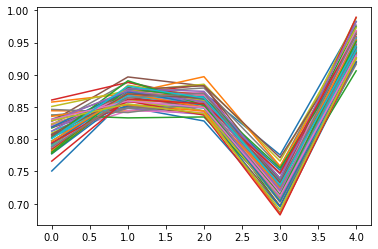

In [248]:
plt.plot(linear_mae_30.T);

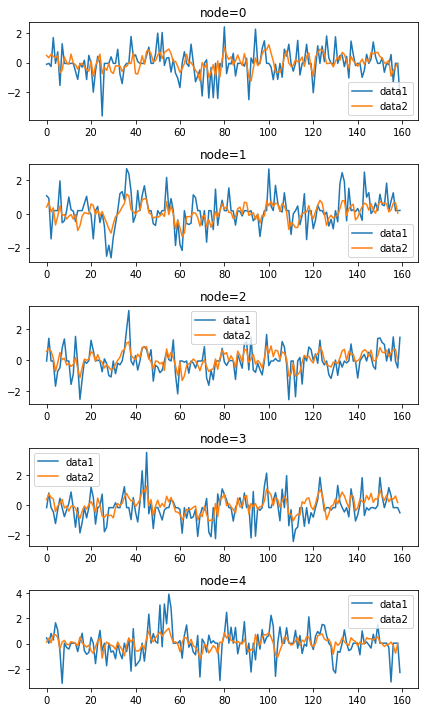

In [249]:
vis2(___zero30.train_mean,_train_result_linear30[59]);

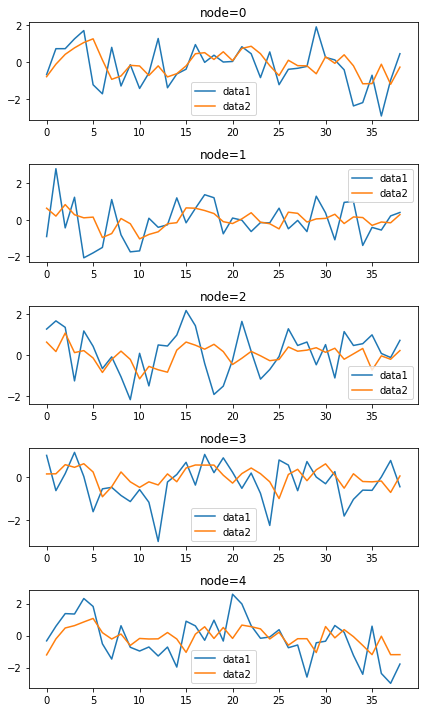

In [250]:
vis2(fiveVTS_test[1:],_test_result_linear30[0]);

In [416]:
show_lrpr(fiveVTS_test[1:,0],fiveVTS_test[1:,1],fiveVTS_test[1:,2],fiveVTS_test[1:,3],fiveVTS_test[1:,4],_test_result_linear30)

# missing : 40%

In [251]:
train_X_mean = torch.tensor(_zero.train_mean).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
train_y_mean = torch.tensor(_zero.train_mean).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [252]:
train_X_linear = torch.tensor(_zero.train_linear).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
train_y_linear = torch.tensor(_zero.train_linear).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [253]:
___zero40 = Missing(fiveVTS_train)

In [254]:
___zero40.miss(percent = 0.4)

In [255]:
___zero40.first_mean()

In [256]:
___zero40.second_linear()

## Mean

In [257]:
t1= time.time()
ttt = 160
_mse = []
_mae = []
_train_result = []
_test_result = []
b = ___zero40.train_mean
c = ___zero40.number
d = train_X_mean
f = train_y_mean
for i in range(60):
    a = Method(b,ttt,c,d,f)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    _train_result.append(a.train_result)
    _test_result.append(a.test_result)
    b = a.FT_result
t2 = time.time()
t2-t1

100%|██████████| 100/100 [00:54<00:00,  1.85it/s]

In [258]:
mean_mse_40 = pd.DataFrame(_mse)

In [259]:
mean_mae_40 = pd.DataFrame(_mae)

In [260]:
_train_result_mean40 = _train_result.copy()

In [261]:
_test_result_mean40 = _test_result.copy()

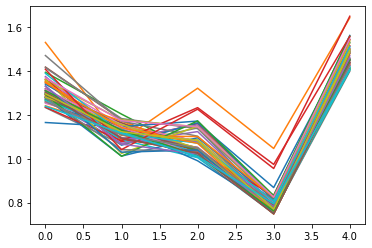

In [262]:
plt.plot(mean_mse_40.T);

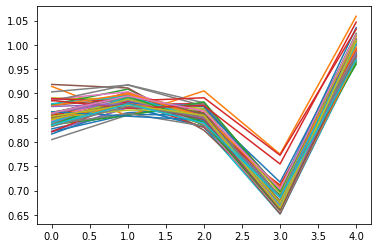

In [263]:
plt.plot(mean_mae_40.T);

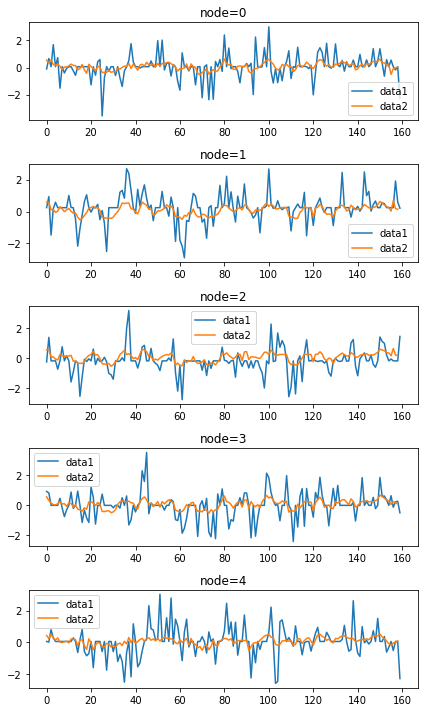

In [264]:
vis2(___zero40.train_mean,_train_result_mean40[59]);

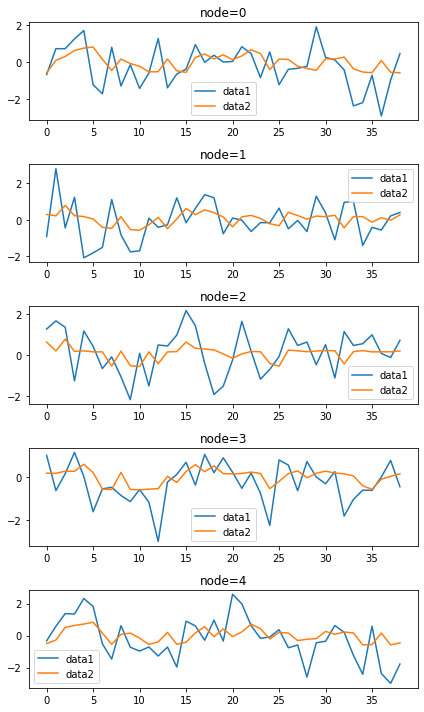

In [265]:
vis2(fiveVTS_test[1:],_test_result_mean40[0]);

In [417]:
show_lrpr(fiveVTS_test[1:,0],fiveVTS_test[1:,1],fiveVTS_test[1:,2],fiveVTS_test[1:,3],fiveVTS_test[1:,4],_test_result_mean40)

## Linear

In [266]:
t1= time.time()
ttt = 160
_mse = []
_mae = []
_train_result = []
_test_result = []
b = ___zero40.second_linear
c = ___zero40.number
d = train_X_linear
f = train_y_linear
for i in range(60):
    a = Method(b,ttt,c,d,f)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    _train_result.append(a.train_result)
    _test_result.append(a.test_result)
    b = a.FT_result
t2 = time.time()
t2-t1

100%|██████████| 100/100 [00:54<00:00,  1.84it/s]

In [267]:
linear_mse_40 = pd.DataFrame(_mse)

In [268]:
linear_mae_40 = pd.DataFrame(_mae)

In [269]:
_train_result_linear40 = _train_result.copy()

In [270]:
_test_result_linear40 = _test_result.copy()

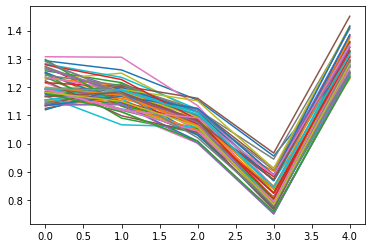

In [271]:
plt.plot(linear_mse_40.T);

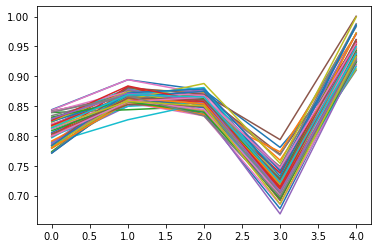

In [272]:
plt.plot(linear_mae_40.T);

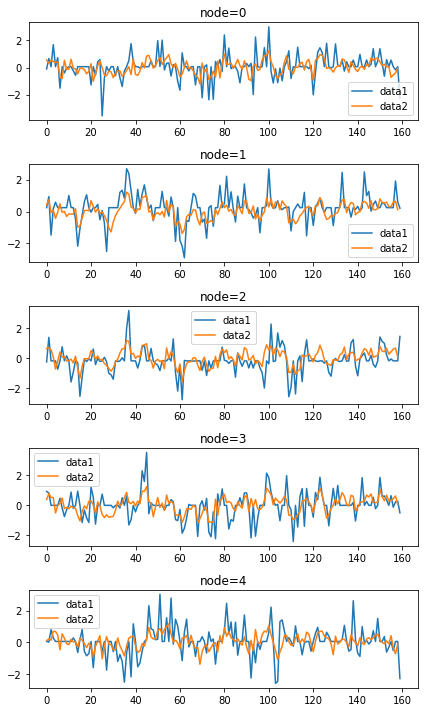

In [273]:
vis2(___zero40.train_mean,_train_result_linear40[59]);

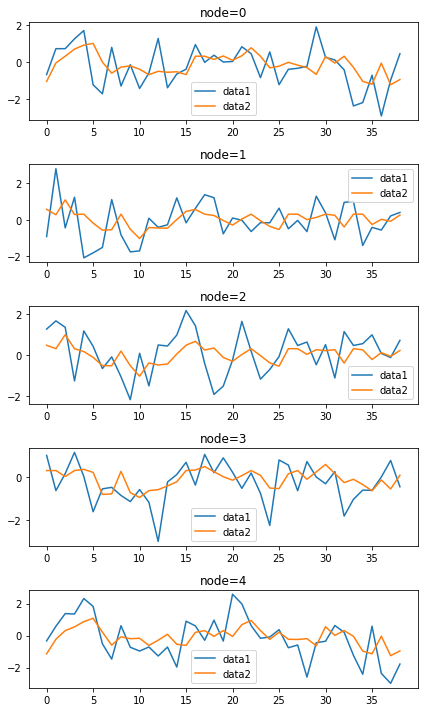

In [274]:
vis2(fiveVTS_test[1:],_test_result_linear40[0]);

In [418]:
show_lrpr(fiveVTS_test[1:,0],fiveVTS_test[1:,1],fiveVTS_test[1:,2],fiveVTS_test[1:,3],fiveVTS_test[1:,4],_test_result_linear40)

# missing : 50%

In [282]:
train_X_mean = torch.tensor(_zero.train_mean).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
train_y_mean = torch.tensor(_zero.train_mean).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [283]:
train_X_linear = torch.tensor(_zero.train_linear).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
train_y_linear = torch.tensor(_zero.train_linear).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [284]:
___zero50 = Missing(fiveVTS_train)

In [285]:
___zero50.miss(percent = 0.5)

In [286]:
___zero50.first_mean()

In [287]:
___zero50.second_linear()

## Mean

In [ ]:
t1= time.time()
ttt = 160
_mse = []
_mae = []
_train_result = []
_test_result = []
b = ___zero50.train_mean
c = ___zero50.number
d = train_X_mean
f = train_y_mean
for i in range(60):
    a = Method(b,ttt,c,d,f)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    _train_result.append(a.train_result)
    _test_result.append(a.test_result)
    b = a.FT_result
t2 = time.time()
t2-t1

In [ ]:
mean_mse_50 = pd.DataFrame(_mse)

In [ ]:
mean_mae_50 = pd.DataFrame(_mae)

In [ ]:
_train_result_mean50 = _train_result.copy()

In [ ]:
_test_result_mean50 = _test_result.copy()

In [ ]:
plt.plot(mean_mse_50.T);

In [ ]:
plt.plot(mean_mae_50.T);

In [ ]:
vis2(_zero.train_mean,_train_result_mean50[59]);

In [ ]:
vis2(fiveVTS_test[1:],_test_result_mean50[0]);

## Linear

In [ ]:
t1= time.time()
ttt = 160
_mse = []
_mae = []
_train_result = []
_test_result = []
b = ___zero50.second_linear
c = ___zero50.number
d = train_X_linear
f = train_y_linear
for i in range(60):
    a = Method(b,ttt,c,d,f)
    a.FT()
    _mse.append(a.mse)
    _mae.append(a.mae)
    _train_result.append(a.train_result)
    _test_result.append(a.test_result)
    b = a.FT_result
t2 = time.time()
t2-t1

In [ ]:
linear_mse_50 = pd.DataFrame(_mse)

In [ ]:
linear_mae_50 = pd.DataFrame(_mae)

In [ ]:
_train_result_linear50 = _train_result.copy()

In [ ]:
_test_result_linear50 = _test_result.copy()

In [ ]:
plt.plot(linear_mse_50.T);

In [ ]:
plt.plot(linear_mae_50.T);

In [ ]:
vis2(_zero.train_mean,_train_result_linear50[59]);

In [ ]:
vis2(fiveVTS_test[1:],_test_result_linear50[0]);